In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import lightgbm
from itertools import product
from sklearn.preprocessing import LabelEncoder
import pickle
import gc
%matplotlib inline

In [2]:
items = pd.read_csv('../sale-prediction/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
shops = pd.read_csv('../sale-prediction/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
cats = pd.read_csv('../sale-prediction/item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
train = pd.read_csv('../sale-prediction/sales_train.csv', parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
test = pd.read_csv('../sale-prediction/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'}).set_index('ID')

In [3]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11
#かぶっている店の名前を変更。ほかにもあって気がするが。
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']] #この二つだけにしちゃうんだ
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id', 'type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

In [5]:
train = train.join(items, on='item_id', rsuffix='_')
train = train.join(shops, on='shop_id', rsuffix='_')
train = train.join(cats, on='item_category_id', rsuffix='_')
train = train.drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,type_code,subtype_code
0,2013-02-01,0,59,22154,999.000000,1,37,30,11,1
1,2013-03-01,0,25,2552,899.000000,1,58,13,13,27
2,2013-05-01,0,25,2552,899.000000,-1,58,13,13,27
3,2013-06-01,0,25,2554,1709.050049,1,58,13,13,27
4,2013-01-15,0,25,2555,1099.000000,1,56,13,13,3
...,...,...,...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.000000,1,55,13,13,2
2935845,2015-09-10,33,25,7460,299.000000,1,55,13,13,2
2935846,2015-10-14,33,25,7459,349.000000,1,55,13,13,2
2935847,2015-10-22,33,25,7440,299.000000,1,57,13,13,8


In [6]:
train = train.query('item_price > 0')

In [7]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_category_id', 'city_code', 'type_code',
       'subtype_code'],
      dtype='object')

In [8]:
train_monthly = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
train_monthly.columns = ['item_cnt_month']
train_monthly.reset_index(inplace=True)
train_monthly = train_monthly.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_')

## matrix再構成

In [9]:
test['date_block_num'] = 34
test = test.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_')

In [10]:
shop_ids = pd.concat([train_monthly['shop_id'],test['shop_id']], ignore_index=True, sort=False).unique()
item_ids = pd.concat([train_monthly['item_id'],test['item_id']], ignore_index=True, sort=False).unique()

empty_df = [[i, shop, item] for i in range(35) for shop in shop_ids for item in item_ids]
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
# concatしてからユニーク取って
# リスト内方表記で書こう
empty_df

,date_block_num,shop_id,item_id
0,0,2,27
1,0,2,33
2,0,2,317
3,0,2,438
4,0,2,471
...,...,...,...
44229145,34,36,15033
44229146,34,36,7572
44229147,34,36,9030
44229148,34,36,1867


In [15]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')

train_monthly.drop(['item_id_','shop_id_'], axis=1, inplace=True)
train_monthly

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,city_code,item_category_id_,type_code,subtype_code
0,0,2,27,1.0,19.0,0.0,19.0,5.0,10.0
1,0,2,33,1.0,37.0,0.0,37.0,11.0,1.0
2,0,2,317,1.0,45.0,0.0,45.0,12.0,23.0
3,0,2,438,1.0,45.0,0.0,45.0,12.0,23.0
4,0,2,471,2.0,49.0,0.0,49.0,12.0,39.0
...,...,...,...,...,...,...,...,...,...
44229145,34,36,15033,NaN,NaN,NaN,NaN,NaN,NaN
44229146,34,36,7572,NaN,NaN,NaN,NaN,NaN,NaN
44229147,34,36,9030,NaN,NaN,NaN,NaN,NaN,NaN
44229148,34,36,1867,NaN,NaN,NaN,NaN,NaN,NaN


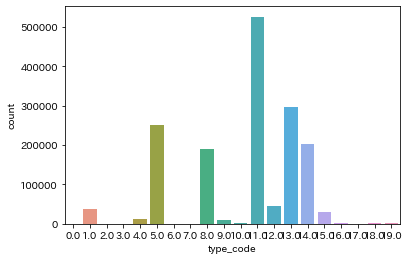

In [18]:
sns.countplot(x='type_code',data=train_monthly)

In [19]:
train_monthly.drop('item_category_id_', axis=1, inplace=True)

In [20]:
train_monthly[train_monthly.date_block_num != 34]

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,city_code,type_code,subtype_code
0,0,2,27,1.0,19.0,0.0,5.0,10.0
1,0,2,33,1.0,37.0,0.0,11.0,1.0
2,0,2,317,1.0,45.0,0.0,12.0,23.0
3,0,2,438,1.0,45.0,0.0,12.0,23.0
4,0,2,471,2.0,49.0,0.0,12.0,39.0
...,...,...,...,...,...,...,...,...
42965455,33,36,15033,NaN,NaN,NaN,NaN,NaN
42965456,33,36,7572,NaN,NaN,NaN,NaN,NaN
42965457,33,36,9030,NaN,NaN,NaN,NaN,NaN
42965458,33,36,1867,NaN,NaN,NaN,NaN,NaN


In [21]:
train_monthly[train_monthly.item_cnt_month == 0]

,date_block_num,shop_id,item_id,item_cnt_month,item_category_id,city_code,type_code,subtype_code
227,0,2,5643,0.0,2.0,0.0,1.0,10.0
45600,0,4,7218,0.0,19.0,2.0,5.0,10.0
66740,0,6,5753,0.0,75.0,4.0,15.0,30.0
67101,0,6,17695,0.0,30.0,4.0,8.0,55.0
67427,0,6,11134,0.0,40.0,4.0,11.0,4.0
...,...,...,...,...,...,...,...,...
42875387,33,48,9361,0.0,70.0,23.0,14.0,57.0
42876083,33,48,5908,0.0,23.0,23.0,5.0,16.0
42897831,33,34,13499,0.0,12.0,15.0,4.0,11.0
42958889,33,36,6847,0.0,55.0,16.0,13.0,2.0


In [17]:
train_monthly[train_monthly.date_block_num != 34].to_pickle('train_core.pickle')

## Test

In [11]:
len(train_monthly) + len(test)

44443350

In [12]:
test

,shop_id,item_id,date_block_num,item_id_,item_category_id,shop_id_,city_code,item_category_id_,type_code,subtype_code
ID,,,,,,,,,,
0,5,5037,34,5037,19,5,3,19,5,10
1,5,5320,34,5320,55,5,3,55,13,2
2,5,5233,34,5233,19,5,3,19,5,10
3,5,5232,34,5232,23,5,3,23,5,16
4,5,5268,34,5268,20,5,3,20,5,11
...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,34,18454,55,45,20,55,13,2
214196,45,16188,34,16188,64,45,20,64,14,42
214197,45,15757,34,15757,55,45,20,55,13,2


In [178]:
test_core = test.to_pickle('test_core.pickle')

In [13]:
matrix = pd.concat([train_monthly, test],ignore_index=True, sort=False)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_id_,item_category_id,shop_id_,city_code,item_category_id_,type_code,subtype_code
0,0,2,27,1.0,27.0,19.0,2.0,0.0,19.0,5.0,10.0
1,0,2,33,1.0,33.0,37.0,2.0,0.0,37.0,11.0,1.0
2,0,2,317,1.0,317.0,45.0,2.0,0.0,45.0,12.0,23.0
3,0,2,438,1.0,438.0,45.0,2.0,0.0,45.0,12.0,23.0
4,0,2,471,2.0,471.0,49.0,2.0,0.0,49.0,12.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...
44443345,34,45,18454,NaN,18454.0,55.0,45.0,20.0,55.0,13.0,2.0
44443346,34,45,16188,NaN,16188.0,64.0,45.0,20.0,64.0,14.0,42.0
44443347,34,45,15757,NaN,15757.0,55.0,45.0,20.0,55.0,13.0,2.0
44443348,34,45,19648,NaN,19648.0,40.0,45.0,20.0,40.0,11.0,4.0


In [54]:
core_matrix = matrix.iloc[:, :11]
core_matrix.to_pickle('core_matrix.pickle')

## 特徴量エンジニアリング

In [14]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = tmp.copy() #forの性質上の理由
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)] #ずらしたカラム名
        shifted['date_block_num'] += i #date_block_numをずらす
        df = pd.merge(df, shifted, on=['date_block_num', 'item_id', 'shop_id'], how='left')
    return df

In [16]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

In [17]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'],how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop('date_avg_item_cnt', axis=1, inplace=True)

In [18]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [19]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [20]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12],'date_cat_avg_item_cnt')
matrix.drop('date_cat_avg_item_cnt', axis=1, inplace=True)

In [21]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [22]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)


In [23]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [24]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [25]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)


In [26]:
group = matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [27]:
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

time.time() - ts

1929.7691714763641

In [28]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [29]:
matrix.to_csv('matrix.csv')

In [34]:
matrix = import_data('matrix.csv')

Memory usage of dataframe is 13563.03 MB
Memory usage after optimization is: 3390.76 MB
Decreased by 75.0%


In [35]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44443350 entries, 0 to 44443349
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   Unnamed: 0                            int32  
 1   date_block_num                        int8   
 2   shop_id                               int8   
 3   item_id                               int16  
 4   item_cnt_month                        float16
 5   item_id_                              float16
 6   item_category_id                      float16
 7   shop_id_                              float16
 8   city_code                             float16
 9   item_category_id_                     float16
 10  type_code                             float16
 11  subtype_code                          float16
 12  item_cnt_month_lag_1                  float16
 13  item_cnt_month_lag_2                  float16
 14  item_cnt_month_lag_3                  float16
 15  item_cnt_mont

In [37]:
matrix.drop('Unnamed: 0', inplace=True, axis=1)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_id_,item_category_id,shop_id_,city_code,item_category_id_,type_code,...,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_6,date_cat_avg_item_cnt_lag_12,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,0,2,27,1.0,27.0,19.0,2.0,0.0,19.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,33,1.0,33.0,37.0,2.0,0.0,37.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,317,1.0,317.0,45.0,2.0,0.0,45.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,438,1.0,438.0,45.0,2.0,0.0,45.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,471,2.0,471.0,49.0,2.0,0.0,49.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## trend feature

In [38]:
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)


In [50]:
group = train.groupby(['date_block_num', 'item_id']).agg({'item_price': 'mean'})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [51]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
    (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [52]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)
# この処理謎な上に超重い

In [53]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

In [55]:
train['revenue'] = train.item_price * train.item_cnt_day
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)
#その月のショップごとの売り上げの合計

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float16)

C:\Users\user\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float16)


In [57]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

In [58]:
matrix.drop(['date_shop_revenue', 'shop_avg_revenue', 'delta_revenue'], axis=1, inplace=True)

In [59]:
ts = time.time()

cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = str(row.item_id) + ' '+ str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num

time.time() - ts
# iterrowsを使わない方法はないのか切実に 

5377.393119573593

In [60]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

3763.134339570999

In [61]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')
#最初に売られた月ってこうやって出すんだ
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

## final preparations

In [62]:
matrix = matrix[matrix.date_block_num > 11]

In [63]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)

In [64]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_id_',
       'item_category_id', 'shop_id_', 'city_code', 'item_category_id_',
       'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6',
       'date_cat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt

In [92]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29279070 entries, 15164280 to 44443349
Data columns (total 45 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   item_id_                              float16
 5   item_category_id                      float16
 6   shop_id_                              float16
 7   city_code                             float16
 8   item_category_id_                     float16
 9   type_code                             float16
 10  subtype_code                          float16
 11  item_cnt_month_lag_1                  float16
 12  item_cnt_month_lag_2                  float16
 13  item_cnt_month_lag_3                  float16
 14  item_cnt_month_lag_6                  float16
 15  item_c

In [97]:
import gc
import pickle

In [99]:
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

In [100]:
matrix.to_pickle('data.pkl')
del matrix

In [137]:
data = pd.read_pickle('data.pkl')

In [138]:
data['year'] = data['date_block_num']//12 + 2013
data['month'] = data['date_block_num'] % 12

In [1]:
data.columns

NameError: name 'data' is not defined

In [140]:
data = data[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id', 'city_code',
       'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6',
       'date_cat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'item_shop_last_sale', 'item_last_sale',
       'item_shop_first_sale', 'item_first_sale', 'year', 'month']]

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29279070 entries, 15164280 to 44443349
Data columns (total 44 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   item_category_id                      float16
 5   city_code                             float16
 6   type_code                             float16
 7   subtype_code                          float16
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_i

In [142]:
import re
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [143]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [144]:
del data

In [145]:
gc.collect();

In [129]:
import lightgbm as lightgbm
ts=time.time()

categorical_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 'month','year', 'type_code', 'subtype_code']
lgb_train = lightgbm.Dataset(X_train, Y_train,
                             categorical_feature=categorical_features)
lgb_eval = lightgbm.Dataset(X_valid, Y_valid,
                            categorical_feature=categorical_features)
#https://www.kaggle.com/koyohoriuchi/starter-code-with-feature-eng-and-lgbm-lb-0-899/edit
params = {'objective' : 'regression',
          'metric' : 'rmse',
          'n_estimators' : 10000,
          'early_stopping_rounds':100,
          "num_leaves" : 150,
          "learning_rate" : 0.05,
          }

model = lightgbm.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=100)

time.time() - ts

C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.647982	valid_1's rmse: 2.02698
[200]	training's rmse: 0.499976	valid_1's rmse: 1.99946
[300]	training's rmse: 0.417085	valid_1's rmse: 1.99706
[400]	training's rmse: 0.366201	valid_1's rmse: 1.99443
Early stopping, best iteration is:
[362]	training's rmse: 0.382805	valid_1's rmse: 1.9889


839.1402869224548

In [125]:
import numpy as np
from sklearn.metrics import mean_squared_error
va_pred = model.predict(X_valid)
score = np.sqrt(mean_squared_error(Y_valid, va_pred))
score

1.9764405388648167

In [148]:
test

,shop_id,item_id,date_block_num,item_id_,item_category_id,shop_id_,city_code,item_category_id_,type_code,subtype_code
ID,,,,,,,,,,
0,5,5037,34,5037,19,5,3,19,5,10
1,5,5320,34,5320,55,5,3,55,13,2
2,5,5233,34,5233,19,5,3,19,5,10
3,5,5232,34,5232,23,5,3,23,5,16
4,5,5268,34,5268,20,5,3,20,5,11
...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,34,18454,55,45,20,55,13,2
214196,45,16188,34,16188,64,45,20,64,14,42
214197,45,15757,34,15757,55,45,20,55,13,2


In [133]:
X_test

,date_block_num,shop_id,item_id,item_category_id,city_code,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,year,month
42965460,34,2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000213,0.000000,NaN,1,1,34,34,2015,10
42965461,34,2,33,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000213,-0.222900,NaN,1,1,34,34,2015,10
42965462,34,2,317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000213,0.000000,NaN,1,1,34,34,2015,10
42965463,34,2,438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000213,0.000000,NaN,1,1,34,34,2015,10
42965464,34,2,471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000213,0.000000,NaN,1,1,34,34,2015,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44443345,34,45,18454,55.0,20.0,13.0,2.0,1.0,0.0,0.0,...,1.329102,1.350586,-0.475098,NaN,0,-1,34,34,2015,10
44443346,34,45,16188,64.0,20.0,14.0,42.0,0.0,0.0,0.0,...,0.000000,0.000213,0.081116,NaN,-1,-1,34,34,2015,10
44443347,34,45,15757,55.0,20.0,13.0,2.0,0.0,0.0,0.0,...,0.000000,0.000213,0.155884,NaN,0,-1,34,34,2015,10
44443348,34,45,19648,40.0,20.0,11.0,4.0,0.0,0.0,0.0,...,0.000000,0.000213,-0.091736,NaN,-1,-1,34,34,2015,10


In [130]:
ts = time.time()

Y_test = model.predict(X_test)

time.time() - ts
sub = pd.DataFrame({'ID': test.index,
                    'item_cnt_month': Y_test})

sub.to_csv('lgbm_lags_sub.csv', index=False)
#そういや形ちげーじゃん

ValueError: arrays must all be same length

In [156]:
X_test_ = pd.merge(test, X_test, on=['shop_id', 'item_id'], how='inner')

In [157]:
X_test_ # なぜか2倍に、、

,shop_id,item_id,date_block_num_x,item_id_,item_category_id_x,shop_id_,city_code_x,item_category_id_,type_code_x,subtype_code_x,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,year,month
0,5,5037,34,5037,19,5,3,19,5,10,...,0.000000,0.000213,-0.222046,NaN,1,-1,34,34,2015,10
1,5,5037,34,5037,19,5,3,19,5,10,...,0.000000,0.000213,-0.222046,NaN,0,-1,34,34,2015,10
2,5,5320,34,5320,55,5,3,55,13,2,...,0.000000,0.000213,0.000000,NaN,-1,-1,34,34,2015,10
3,5,5320,34,5320,55,5,3,55,13,2,...,0.000000,0.000213,0.000000,NaN,-1,-1,34,34,2015,10
4,5,5233,34,5233,19,5,3,19,5,10,...,2.337891,1.641602,0.496826,NaN,1,-1,34,34,2015,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428395,45,15757,34,15757,55,45,20,55,13,2,...,0.000000,0.000213,0.155884,NaN,0,-1,34,34,2015,10
428396,45,19648,34,19648,40,45,20,40,11,4,...,0.000000,0.000213,-0.091736,NaN,-1,-1,34,34,2015,10
428397,45,19648,34,19648,40,45,20,40,11,4,...,0.000000,0.000213,-0.091736,NaN,-1,-1,34,34,2015,10
428398,45,969,34,969,37,45,20,37,11,1,...,0.000000,0.000213,-0.605957,NaN,1,-1,34,34,2015,10


In [160]:
X_test_a = X_test_[::2]
X_test_a.reset_index(inplace=True)
X_test_a
# 無理やり変形

,index,shop_id,item_id,date_block_num_x,item_id_,item_category_id_x,shop_id_,city_code_x,item_category_id_,type_code_x,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,year,month
0,0,5,5037,34,5037,19,5,3,19,5,...,0.000000,0.000213,-0.222046,NaN,1,-1,34,34,2015,10
1,2,5,5320,34,5320,55,5,3,55,13,...,0.000000,0.000213,0.000000,NaN,-1,-1,34,34,2015,10
2,4,5,5233,34,5233,19,5,3,19,5,...,2.337891,1.641602,0.496826,NaN,1,-1,34,34,2015,10
3,6,5,5232,34,5232,23,5,3,23,5,...,0.000000,0.000213,0.505371,NaN,1,-1,34,34,2015,10
4,8,5,5268,34,5268,20,5,3,20,5,...,0.000000,0.000213,0.000000,NaN,-1,-1,34,34,2015,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,428390,45,18454,34,18454,55,45,20,55,13,...,1.329102,1.350586,-0.475098,NaN,1,-1,34,34,2015,10
214196,428392,45,16188,34,16188,64,45,20,64,14,...,0.000000,0.000213,0.081116,NaN,-1,-1,34,34,2015,10
214197,428394,45,15757,34,15757,55,45,20,55,13,...,0.000000,0.000213,0.155884,NaN,1,-1,34,34,2015,10
214198,428396,45,19648,34,19648,40,45,20,40,11,...,0.000000,0.000213,-0.091736,NaN,-1,-1,34,34,2015,10


In [166]:
len(X_test_a.columns)

52

In [165]:
X_test_a.columns

Index(['index', 'shop_id', 'item_id', 'date_block_num_x', 'item_id_',
       'item_category_id_x', 'shop_id_', 'city_code_x', 'item_category_id_',
       'type_code_x', 'subtype_code_x', 'date_block_num_y',
       'item_category_id_y', 'city_code_y', 'type_code_y', 'subtype_code_y',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_cat_avg_item_cnt_lag_2', 'date_cat_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_12',
       'date_shop_ca

In [171]:
X_test_b = X_test_a[[ 'shop_id', 'item_id',
         'city_code_x', 'item_category_id_',
       'type_code_x', 'subtype_code_x', 'date_block_num_y',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_cat_avg_item_cnt_lag_1',
       'date_cat_avg_item_cnt_lag_2', 'date_cat_avg_item_cnt_lag_3',
       'date_cat_avg_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_12',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'item_shop_last_sale', 'item_last_sale',
       'item_shop_first_sale', 'item_first_sale', 'year', 'month']]

In [174]:
X_test_c = X_test_b.rename(columns={'city_code_x': 'city_code',
                                    'type_code_x': 'type_code',
                                    'subtype_code_x': 'subtype_code',
                                    'date_block_num_y':'date_block_num'})

In [175]:
ts = time.time()

Y_test = model.predict(X_test_c)

time.time() - ts
sub = pd.DataFrame({'ID': test.index,
                    'item_cnt_month': Y_test})

sub.to_csv('shakyo3_sub.csv', index=False)
#3.92681

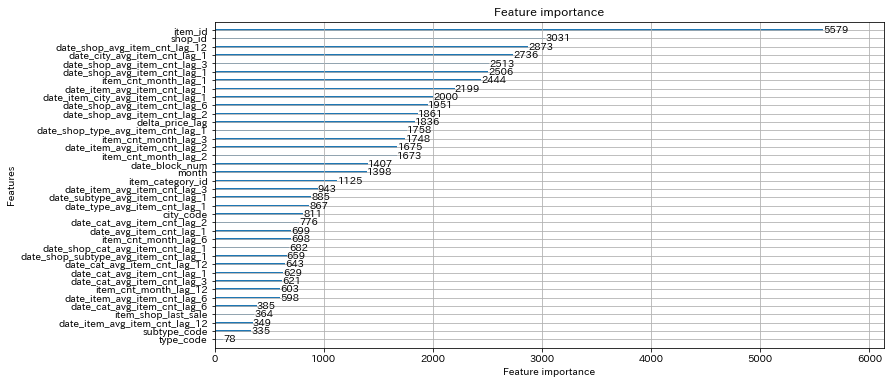

In [176]:
lightgbm.plot_importance(model, figsize=(12, 6))